In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import gzip

# For NLP processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import pos_tag
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# For topic modeling
from gensim import corpora, models

# For visualization of topics
from wordcloud import WordCloud

# For statistical analysis
from scipy.stats import (
    chi2_contingency, chi2, ttest_ind, mannwhitneyu,
    entropy, ks_2samp
)

# For embeddings and similarity calculations
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Data loading
from src.data.beerdata_loader import BeerDataLoader

# To show progress
from tqdm import tqdm

#For multiprocessing
from multiprocessing import Pool

#For shapefiles
import geopandas as gpd

import os
import pickle

from gensim.models import LdaModel
from gensim.corpora import Dictionary

tqdm.pandas()
from collections import Counter
import plotly.express as px

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Qrnqult\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Qrnqult\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Qrnqult\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Qrnqult\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Qrnqult\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
import json
with open('src/data/partition.json', 'r') as f:
    partition = json.load(f)

In [3]:
result_df = pd.read_csv('src/data/beer_word_counts2.csv')

In [4]:
print(result_df.keys().size)


1015


In [5]:
with open('src/data/beer_name_dict.pkl', 'rb') as f:
    beer_name_dict = pickle.load(f)

In [94]:
data_loader = BeerDataLoader(data_dir="../ada-2024-project-data-crusadas/src/data/BeerAdvocate", force_process=False)

ba_reviews_df, ba_ratings_df, ba_beers_df, ba_breweries_df, ba_users_df = data_loader.load_all_data()

Processed file '../ada-2024-project-data-crusadas/src/data/BeerAdvocate\reviews_processed.csv' already exists. Skipping processing.
Processed file '../ada-2024-project-data-crusadas/src/data/BeerAdvocate\ratings_processed.csv' already exists. Skipping processing.


In [104]:
interesting_rating = ba_ratings_df[['beer_id', 'appearance', 'aroma', 'palate', 'taste', 'rating']]
mean_ratings = interesting_rating.groupby('beer_id').mean().reset_index()

In [105]:
merged_df_beers = pd.merge(ba_beers_df, mean_ratings, on='beer_id', how='right')

In [106]:
# get the top rated beers in each cluster
result_df['beer_id'] = result_df['beer_id'].astype(str)
result_df['cluster'] = result_df['beer_id'].map(partition)
result_df['beer_id'] = result_df['beer_id'].astype(int)

In [107]:
assigned_cluster = pd.merge(result_df[['beer_id', 'cluster']], merged_df_beers, on='beer_id', how='inner')

In [84]:
for i in range(0,9):
    beer = assigned_cluster[assigned_cluster['cluster'] == i]
    style_counts = beer['style'].value_counts()

    # Filter styles with more than 100 beers
    popular_styles = style_counts[0:5]
    print(f"-----------Cluster {i}------------------")
    print(popular_styles)
    print("Mean ABV: ", beer['abv'].mean())
    print("Mean rating: ", beer['rating'].mean())
    #print("Mean palate: ", beer['palate'].mean())
    #print("Mean taste: ", beer['taste'].mean())
    #print("Mean appearance: ", beer['appearance'].mean())

-----------Cluster 0------------------
style
American Pale Ale (APA)    2543
German Pilsener            1581
American IPA               1457
Euro Pale Lager            1349
American Blonde Ale         984
Name: count, dtype: int64
Mean ABV:  5.407504175365345
Mean rating:  3.4658906
-----------Cluster 1------------------
style
American Double / Imperial Stout    866
American Porter                     424
Russian Imperial Stout              325
American Strong Ale                 241
American Barleywine                 235
Name: count, dtype: int64
Mean ABV:  9.553595030399155
Mean rating:  4.013752
-----------Cluster 2------------------
style
American IPA                      7941
American Double / Imperial IPA    3793
American Pale Ale (APA)           3013
English India Pale Ale (IPA)       642
American Amber / Red Ale           408
Name: count, dtype: int64
Mean ABV:  6.754230566457736
Mean rating:  3.8550165
-----------Cluster 3------------------
style
American Porter              

In [13]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    # Lowercase
    text = text.lower()
    # Tokenize with preserve_line=True to avoid sent_tokenize
    tokens = word_tokenize(text, preserve_line=True)
    # Remove punctuation and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return tokens

In [14]:
def filter_beer_reviews(ipa_reviews_df, non_ipa_reviews_df):
    # Set parameters
    review_threshold = 100  # Minimum number of reviews a beer must have
    max_reviews_per_beer = 1000  # Maximum number of reviews to process per beer
    sample_size = 100000  # Total reviews to process per category

    ipa_size = (ipa_reviews_df.shape[0])
    if ipa_size < 100000 and ipa_size > 40000:
        review_threshold = 10
    elif ipa_size < 40000:
        review_threshold = 1

    # For IPA reviews
    ipa_review_counts = ipa_reviews_df['beer_id'].value_counts()
    ipa_beers_selected = ipa_review_counts[ipa_review_counts >= review_threshold].index.tolist()

    ipa_reviews_filtered = ipa_reviews_df[ipa_reviews_df['beer_id'].isin(ipa_beers_selected)]
    ipa_reviews_filtered = ipa_reviews_filtered.groupby('beer_id').head(max_reviews_per_beer).reset_index(drop=True)

    # For Non-IPA reviews
    non_ipa_review_counts = non_ipa_reviews_df['beer_id'].value_counts()
    non_ipa_beers_selected = non_ipa_review_counts[non_ipa_review_counts >= review_threshold].index.tolist()

    non_ipa_reviews_filtered = non_ipa_reviews_df[non_ipa_reviews_df['beer_id'].isin(non_ipa_beers_selected)]
    non_ipa_reviews_filtered = non_ipa_reviews_filtered.groupby('beer_id').head(max_reviews_per_beer).reset_index(drop=True)

    # Sample to reduce data size
    sample_size = min(sample_size, ipa_reviews_filtered.shape[0])
    ipa_reviews_filtered = ipa_reviews_filtered.sample(n=sample_size, random_state=42)
    non_ipa_reviews_filtered = non_ipa_reviews_filtered.sample(n=sample_size, random_state=42)

    print("Total number of selected IPA reviews:", len(ipa_reviews_filtered))
    print("Total number of selected Non-IPA reviews:", len(non_ipa_reviews_filtered))
    return ipa_reviews_filtered, non_ipa_reviews_filtered

In [15]:
def tokenize(ipa_reviews_filtered, non_ipa_reviews_filtered):
    # Apply preprocessing
    #print("Preprocessing IPA reviews...")
    ipa_reviews_filtered['tokens'] = ipa_reviews_filtered['text'].progress_apply(preprocess_text)

    #print("Preprocessing Non-IPA reviews...")
    non_ipa_reviews_filtered['tokens'] = non_ipa_reviews_filtered['text'].progress_apply(preprocess_text)

    # Remove entries with empty tokens
    ipa_reviews_filtered = ipa_reviews_filtered[ipa_reviews_filtered['tokens'].str.len() > 0].reset_index(drop=True)
    non_ipa_reviews_filtered = non_ipa_reviews_filtered[non_ipa_reviews_filtered['tokens'].str.len() > 0].reset_index(drop=True)

    #print(f"Total IPA reviews after preprocessing: {len(ipa_reviews_filtered)}")
    #print(f"Total Non-IPA reviews after preprocessing: {len(non_ipa_reviews_filtered)}")
    return ipa_reviews_filtered, non_ipa_reviews_filtered

In [16]:
def extract_top_words(ipa_reviews_filtered, non_ipa_reviews_filtered):
    
    ipa_tokens_list = ipa_reviews_filtered['tokens'].tolist()
    non_ipa_tokens_list = non_ipa_reviews_filtered['tokens'].tolist()
    return ipa_tokens_list, non_ipa_tokens_list


In [17]:
def compute_criterium(ipa_tokens_list, non_ipa_tokens_list, descriptor):
     
    def count_appearance(tokens_list, flavor_list):
        flavor_counts = dict.fromkeys(flavor_list, 0)
        for tokens in tokens_list:
            for token in tokens:
                if token in flavor_list:
                    flavor_counts[token] += 1
        return flavor_counts

    # Count flavors in IPA and Non-IPA reviews
    ipa_appearance_counts = count_appearance(ipa_tokens_list, descriptor)
    non_ipa_appearance_counts = count_appearance(non_ipa_tokens_list, descriptor)

    # Convert to DataFrame
    ipa_appearance_df = pd.DataFrame(list(ipa_appearance_counts.items()), columns=['Appear', 'Count_IPA'])
    non_ipa_appearance_df = pd.DataFrame(list(non_ipa_appearance_counts.items()), columns=['Appear', 'Count_Non_IPA'])
    comparison_df = ipa_appearance_df.merge(non_ipa_appearance_df, on='Appear')
    comparison_df['Difference'] = comparison_df['Count_IPA'] - comparison_df['Count_Non_IPA']
    return comparison_df


In [18]:
flavor_descriptors = [
    'hoppy', 'bitter', 'citrus', 'pine', 'floral', 'malty', 'sweet', 'roasted', 'caramel',
    'chocolate', 'coffee', 'fruit', 'spicy', 'herbal', 'earthy', 'toffee', 'tropical', 'yeast',
    'banana', 'clove', 'smoke', 'oak', 'vanilla', 'nutty', 'wheat', 'grain', 'sour', 'tart', 'milk', 'coriander'
]
appearance_descriptors = [
    'head', 'dark', 'brown', 'light', 'white', 'golden', 'straw', 'orange', 'yellow', 'pale', 'hazy', 'opaque', 'amber'
]

In [19]:
def print_cloud(appearance_comparison_df, flavor_comparison_df, cluster_nb):
    
    # Generate word cloud for appearance
    ipa_word_freq = dict(zip(appearance_comparison_df['Appear'], appearance_comparison_df['Difference']))
    ipa_wordcloud = WordCloud(
        width=800, height=400, background_color='white', 
        color_func=lambda *args, **kwargs: 'grey'  # Solid grey color
    )
    ipa_wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=lambda *args, **kwargs: 'blue').generate_from_frequencies(ipa_word_freq)

    # Generate word cloud for Non-IPA
    non_ipa_word_freq = dict(zip(flavor_comparison_df['Appear'], flavor_comparison_df['Difference']))
    non_ipa_wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=lambda *args, **kwargs: 'orange').generate_from_frequencies(non_ipa_word_freq)

    # Plot word clouds
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(ipa_wordcloud, interpolation='bilinear')
    plt.title(f'Appearance Descriptors {cluster_nb}', size=20)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(non_ipa_wordcloud, interpolation='bilinear')
    plt.title(f'Flavor Descriptors {cluster_nb}', size=20)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [20]:
def create_sunburst(cluster_nbr, assigned_cluster, cluster_name, color):
    # Assuming 'style' column exists
    beer = assigned_cluster[assigned_cluster['cluster'] == cluster_nbr]
    style_counts = beer['style'].value_counts()
    #Take only top 5 popular styles
    popular_styles = style_counts[0:5]
    popular_styles = popular_styles.reset_index()
    popular_styles.columns = ['Style', 'Count']

    # Add "Others" to the DataFrame
    others_count = style_counts.iloc[5:].sum()  # Sum counts of styles outside the top 5
    #if others_count > 0:  # Add only if there are remaining styles
    #    others_row = pd.DataFrame({'Style': ['Others'], 'Count': [others_count]})
    #    popular_styles = pd.concat([popular_styles, others_row], ignore_index=True)
    
    # Optionally, if there are sub-categories, include them
    # For simplicity, we'll assume 'style' is the only category
    
    fig = px.sunburst(popular_styles, path=['Style'], values='Count',
                      title=f'Style Distribution in {cluster_name}',
                      color='Count', 
                      color_continuous_scale='Reds' if color=='darkred' else 'Blues')
    
    fig.add_annotation(
        x=0.9,  # Center of the sunburst
        y=-0.2,  # Place below the chart
        text=f'Other styles: {others_count}',
        showarrow=False,
        font=dict(size=14, color='darkred')
    )
    
    fig.show()

In [31]:
from IPython.display import Image, display
from glob import glob

# Path to the image file
image_path = "./src/data/beer_images/"
all_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]
print(image_path + all_files[0])

./src/data/beer_images/C0_LightAndRefreshingLagers.png


<div style="font-size:32px; font-weight:bold;">Beer clusters</div>

We are a consulting compagny. We want to provide a service to breweries. To do so we want to be able, from our data, to identify the trends that users follow. To do so, we first need to identify, based on the key words of beers taken from the reviews, the key characteristics that differenciate the most the different kinds of beers. To do so, we extracted the keys words and tried to cluster each beer based on those key words. Then we tried to identify the top 5 beer styles corresponding to the cluster and why flavors and appearance trait correspond to the cluster.

Cluster 0


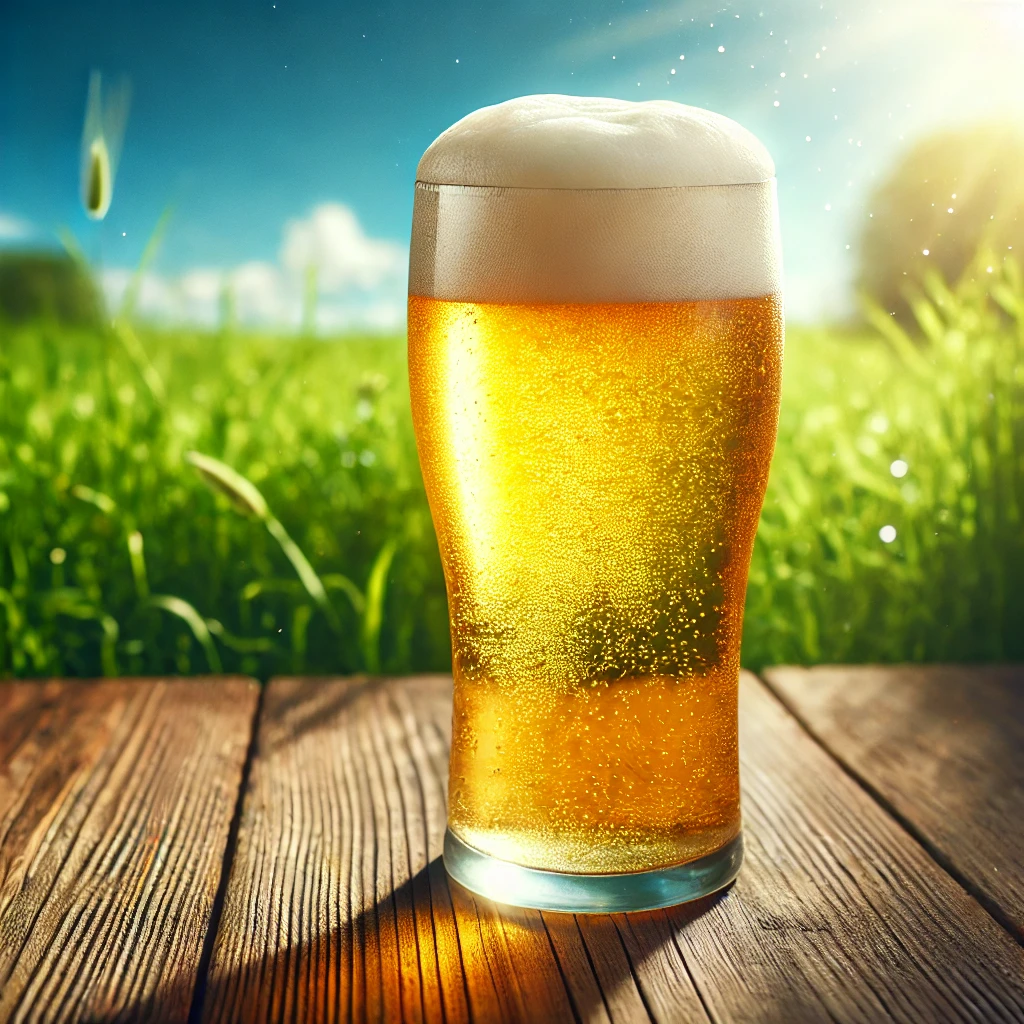

Total number of selected IPA reviews: 100000
Total number of selected Non-IPA reviews: 100000


100%|██████████| 100000/100000 [01:26<00:00, 1159.08it/s]


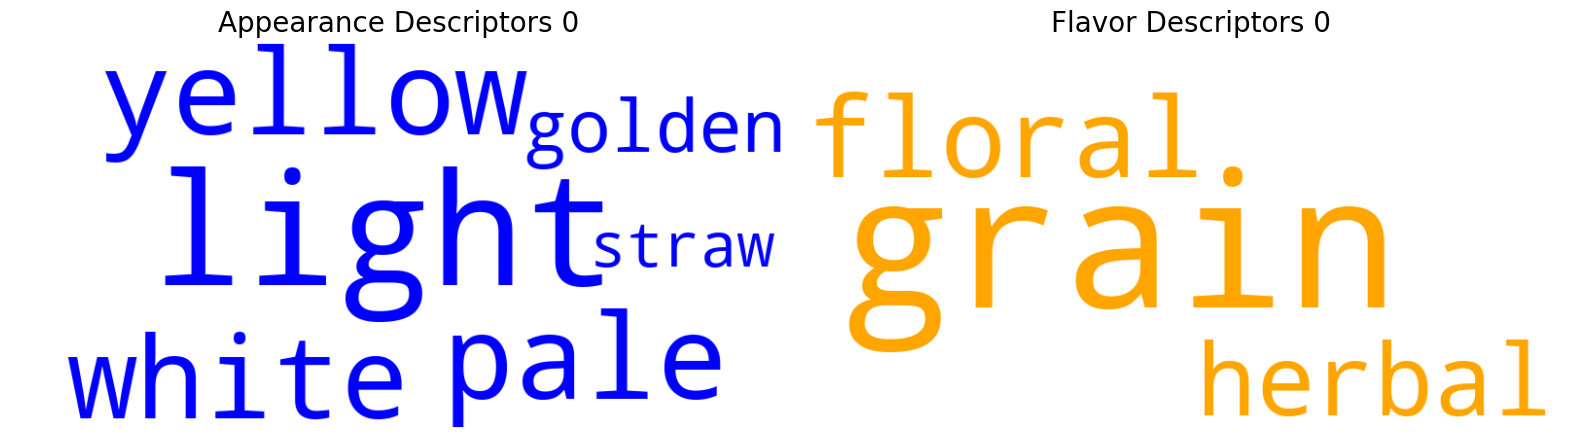

Cluster 1


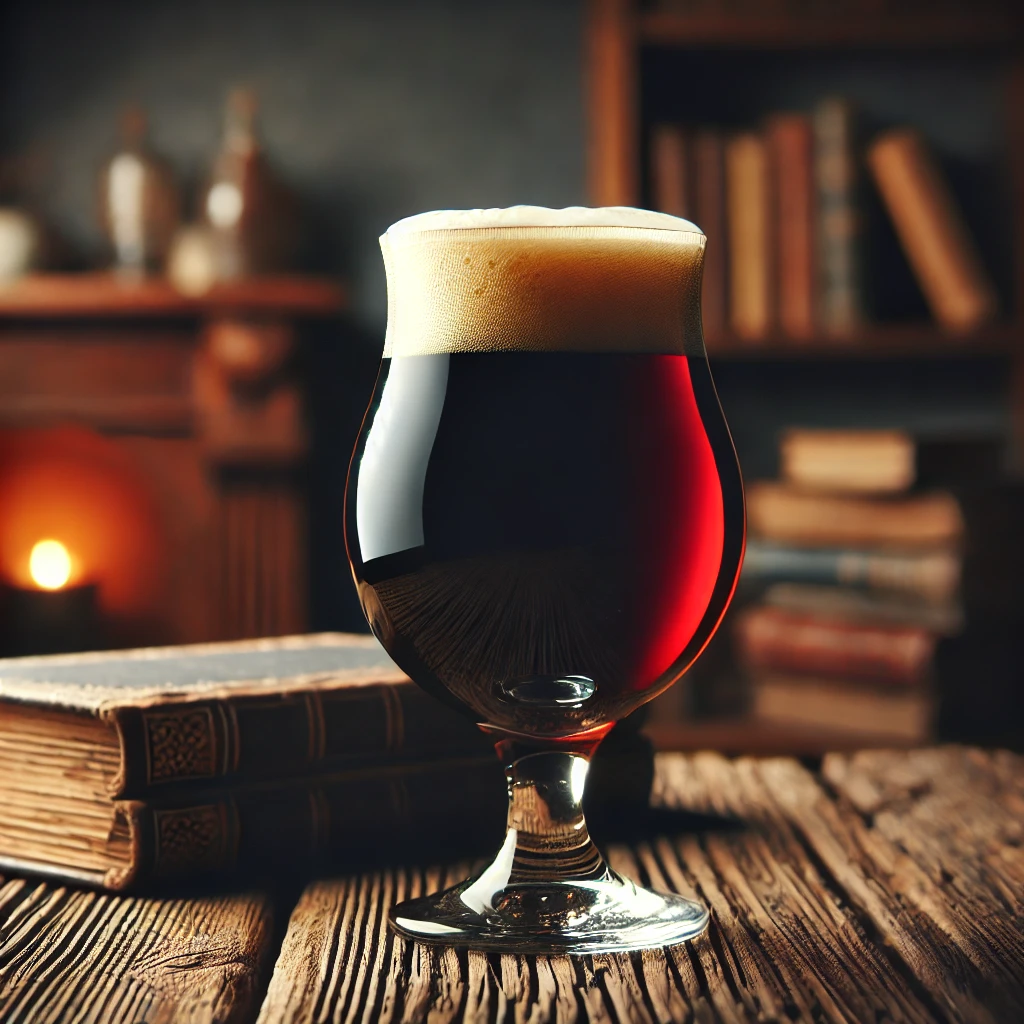

Total number of selected IPA reviews: 59467
Total number of selected Non-IPA reviews: 59467


100%|██████████| 59467/59467 [00:48<00:00, 1222.63it/s]


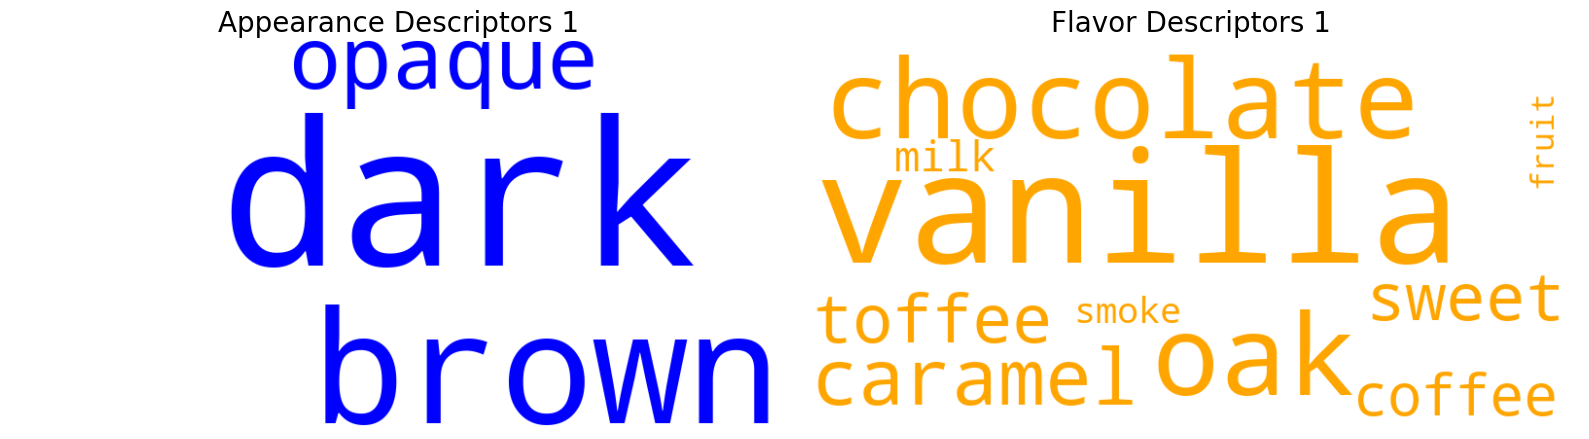

Cluster 2


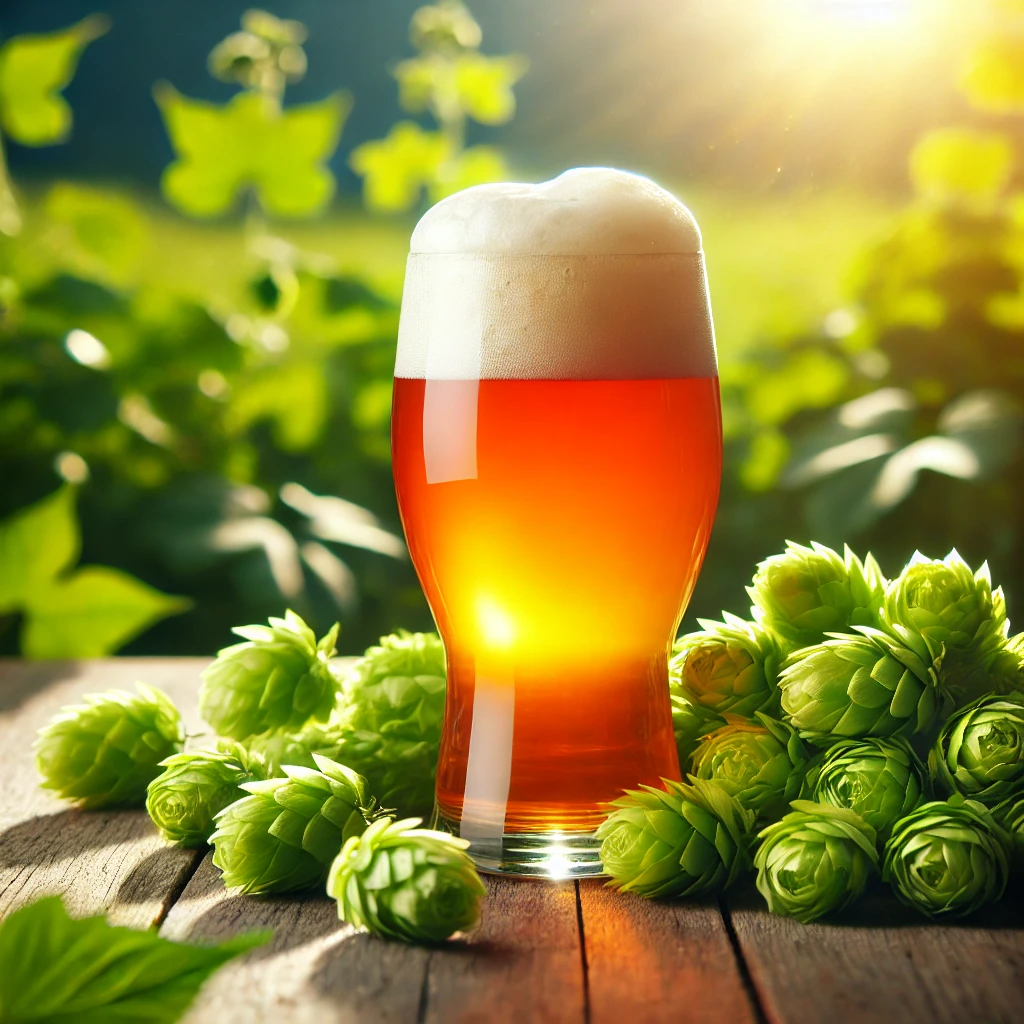

Total number of selected IPA reviews: 100000
Total number of selected Non-IPA reviews: 100000


100%|██████████| 100000/100000 [01:34<00:00, 1059.13it/s]


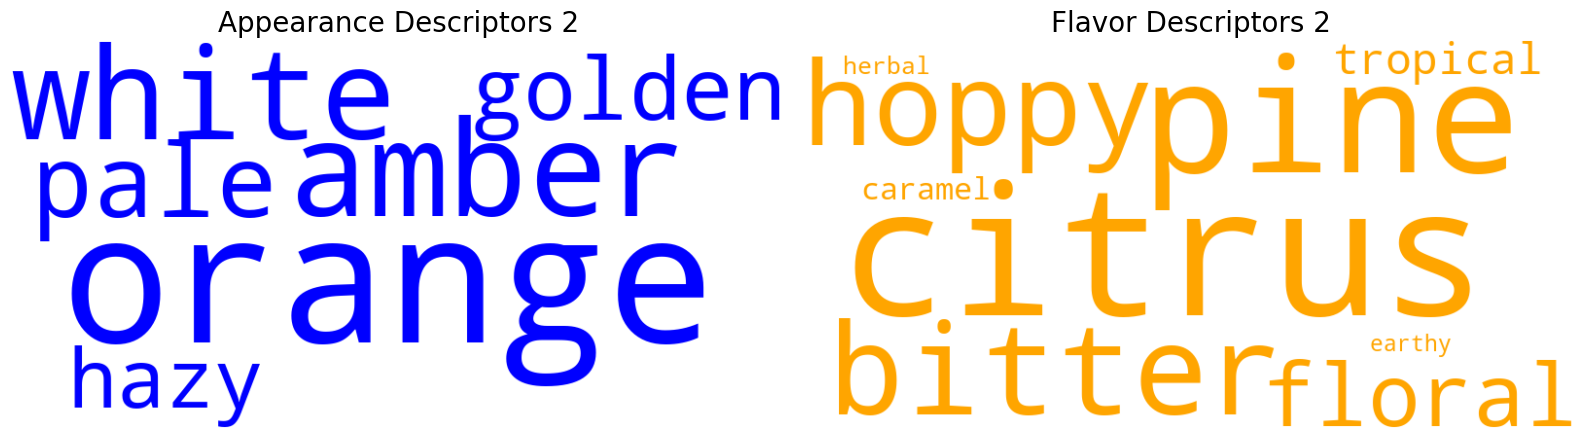

Cluster 3


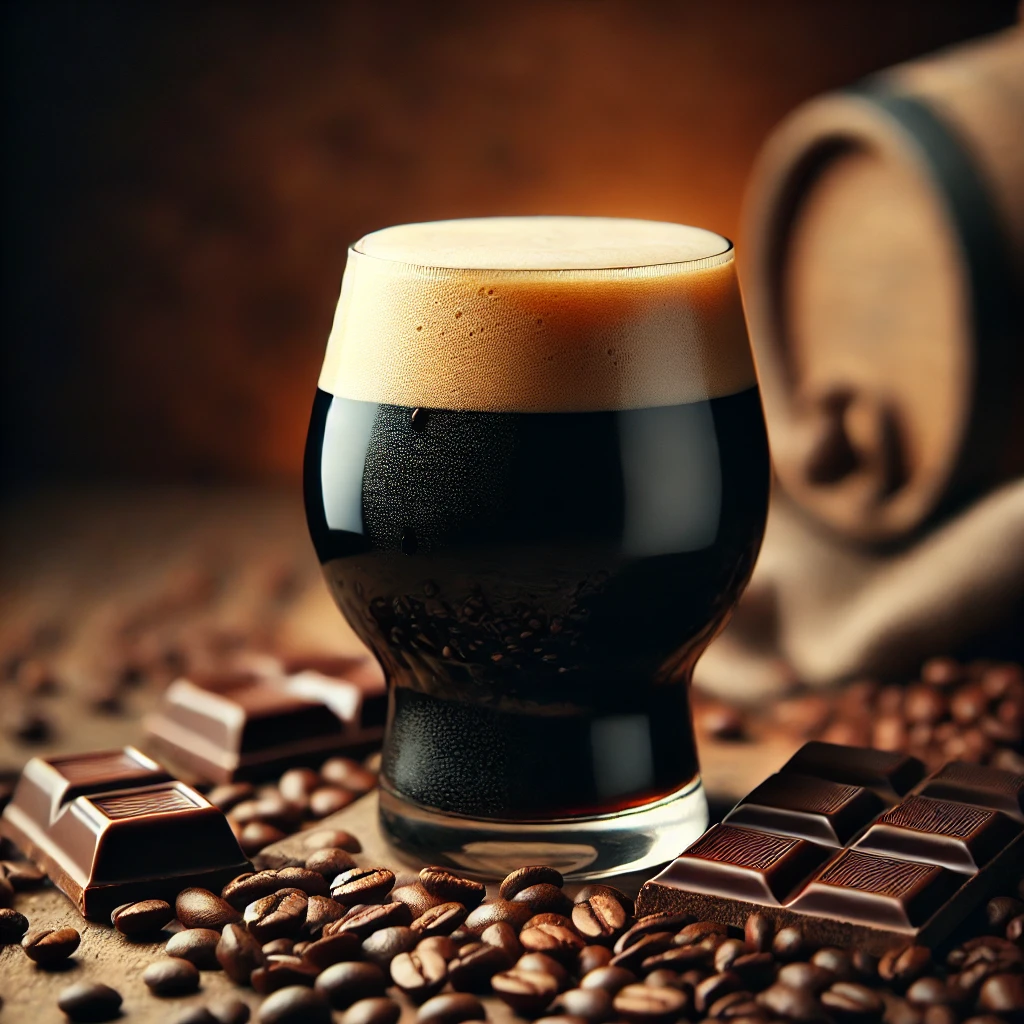

Total number of selected IPA reviews: 100000
Total number of selected Non-IPA reviews: 100000


100%|██████████| 100000/100000 [01:19<00:00, 1259.63it/s]


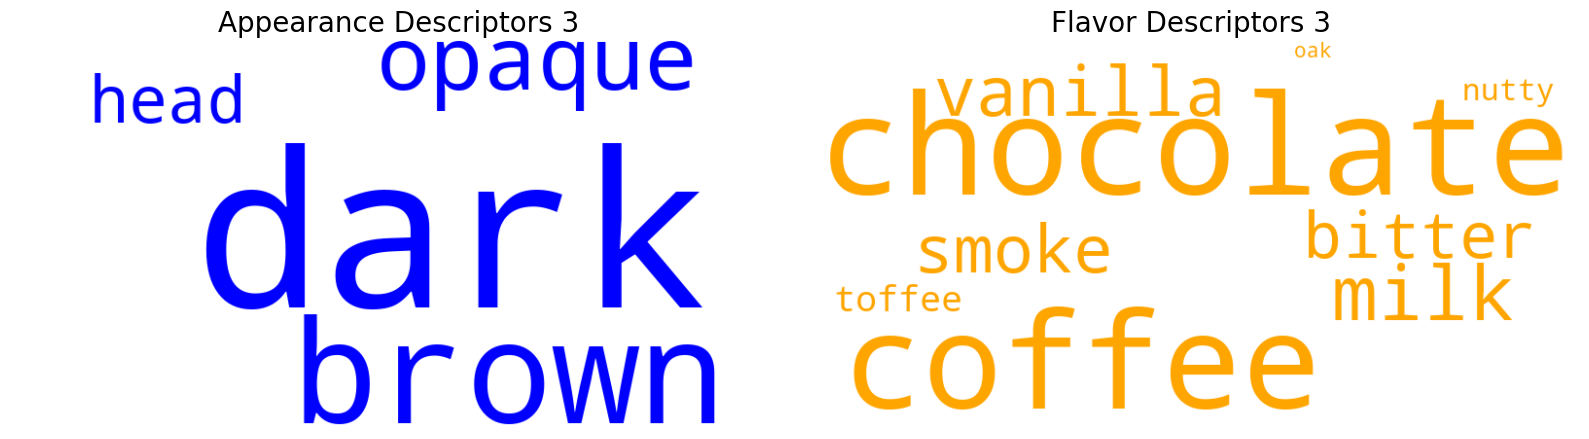

Cluster 4


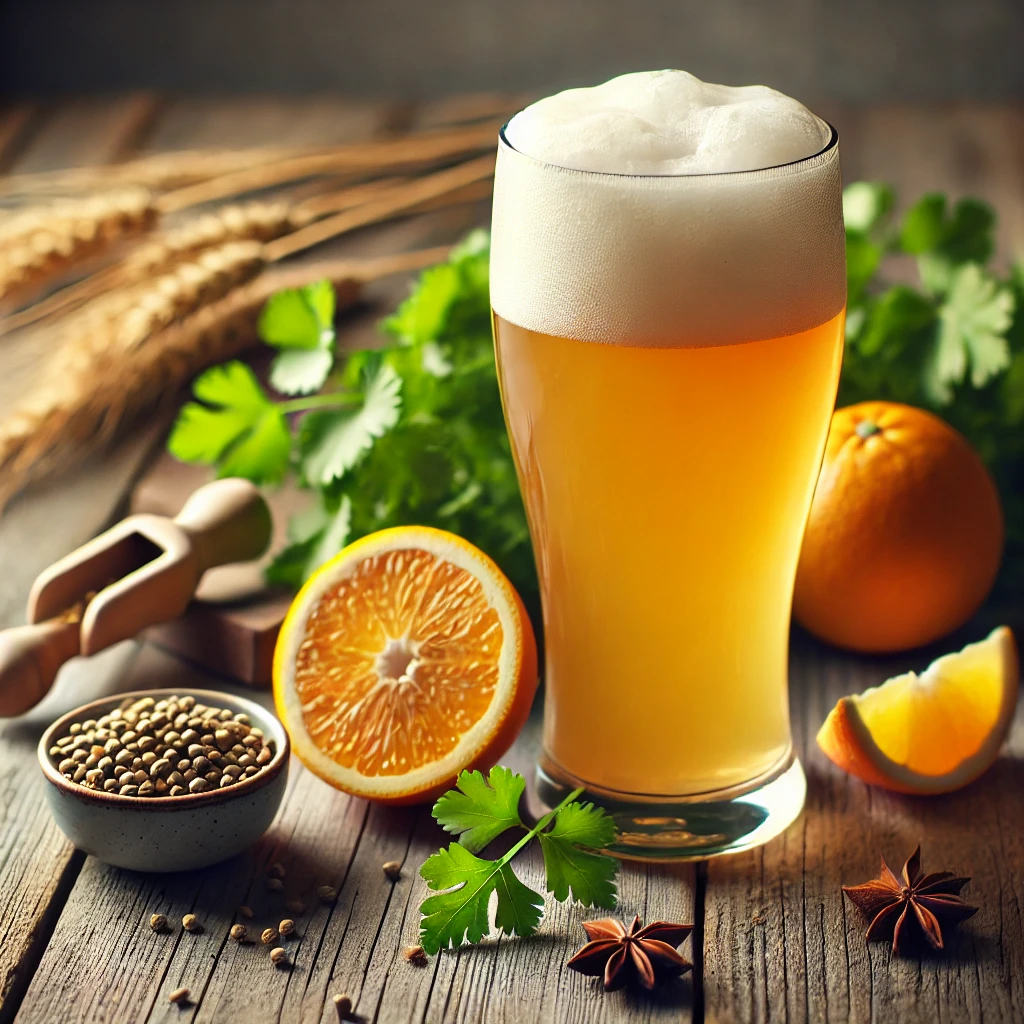

Total number of selected IPA reviews: 100000
Total number of selected Non-IPA reviews: 100000


100%|██████████| 100000/100000 [02:09<00:00, 769.64it/s]


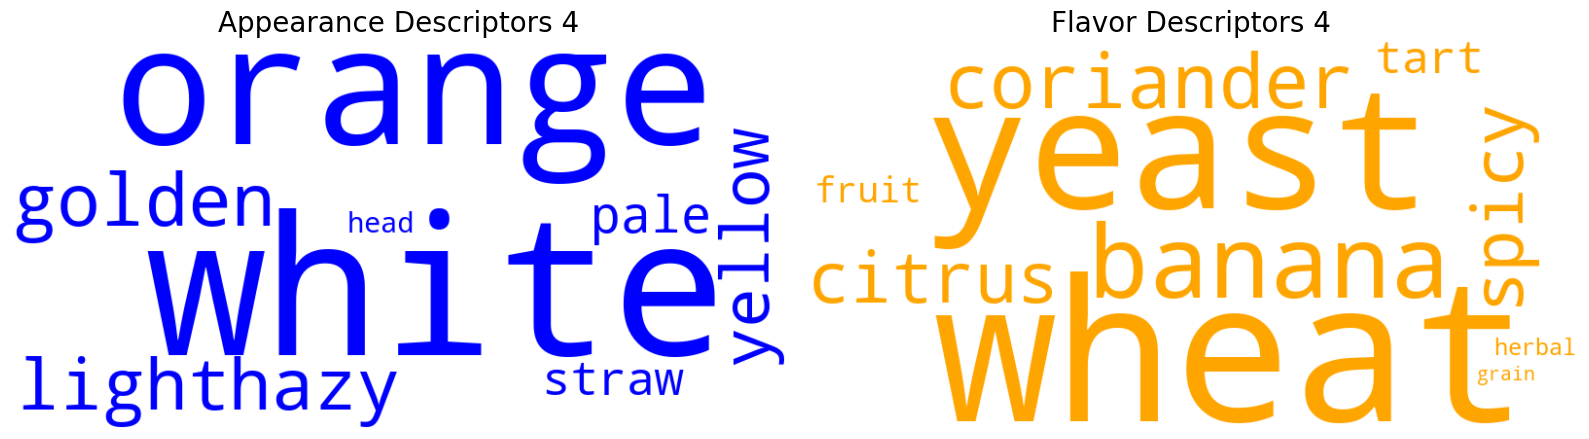

Cluster 5


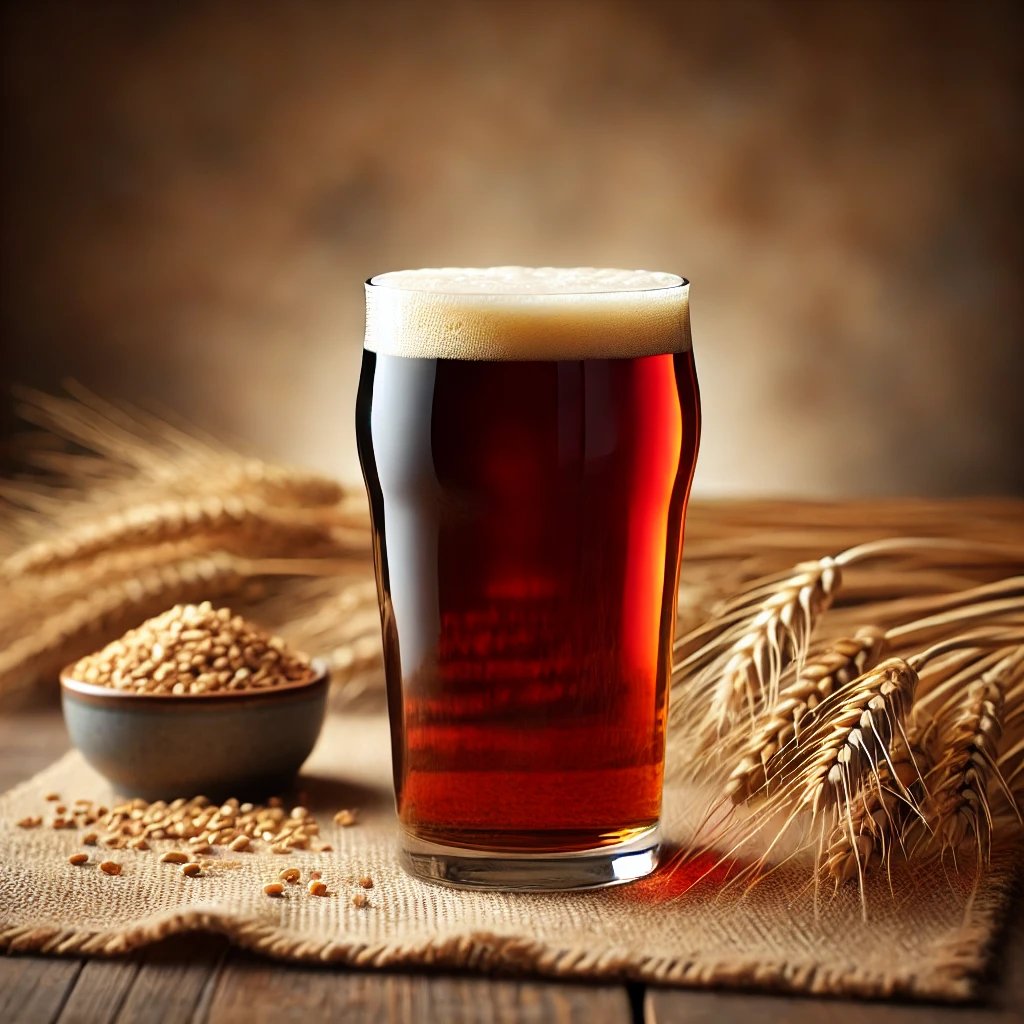

Total number of selected IPA reviews: 100000
Total number of selected Non-IPA reviews: 100000


100%|██████████| 100000/100000 [01:25<00:00, 1170.29it/s]


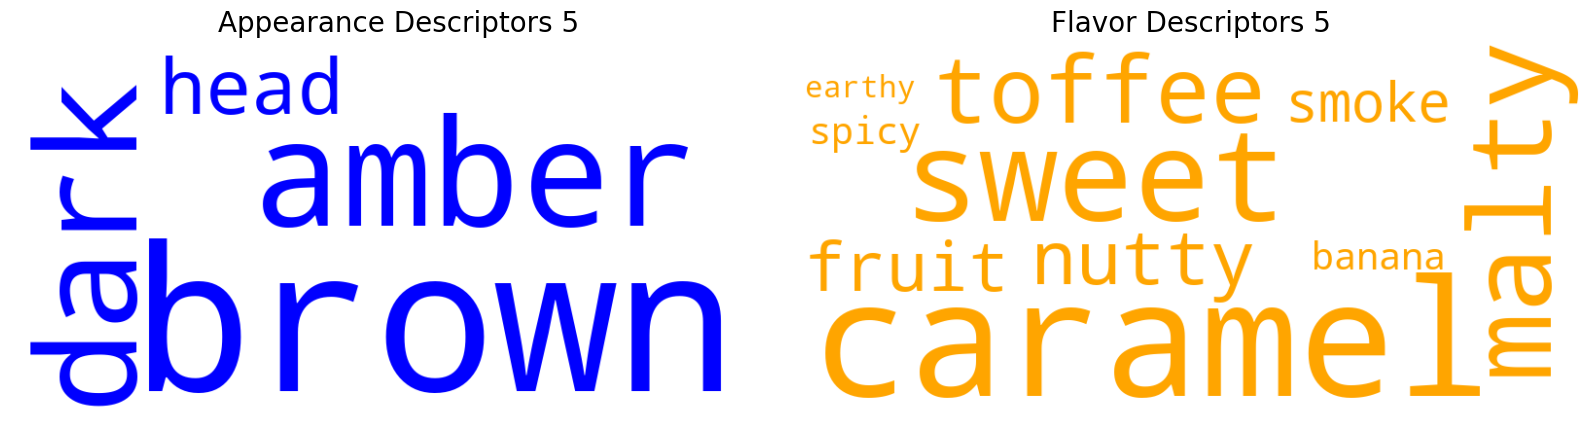

Cluster 6


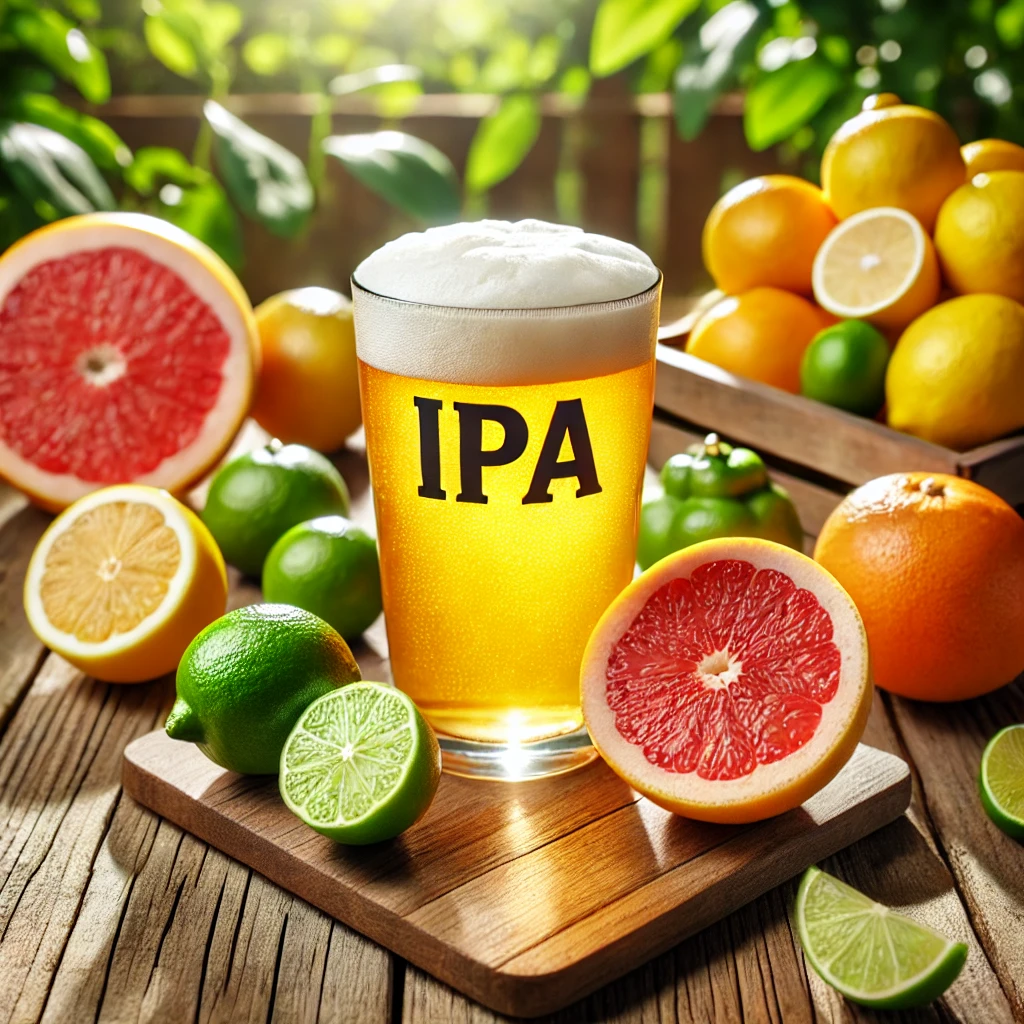

Total number of selected IPA reviews: 23920
Total number of selected Non-IPA reviews: 23920


100%|██████████| 23920/23920 [00:22<00:00, 1049.33it/s]


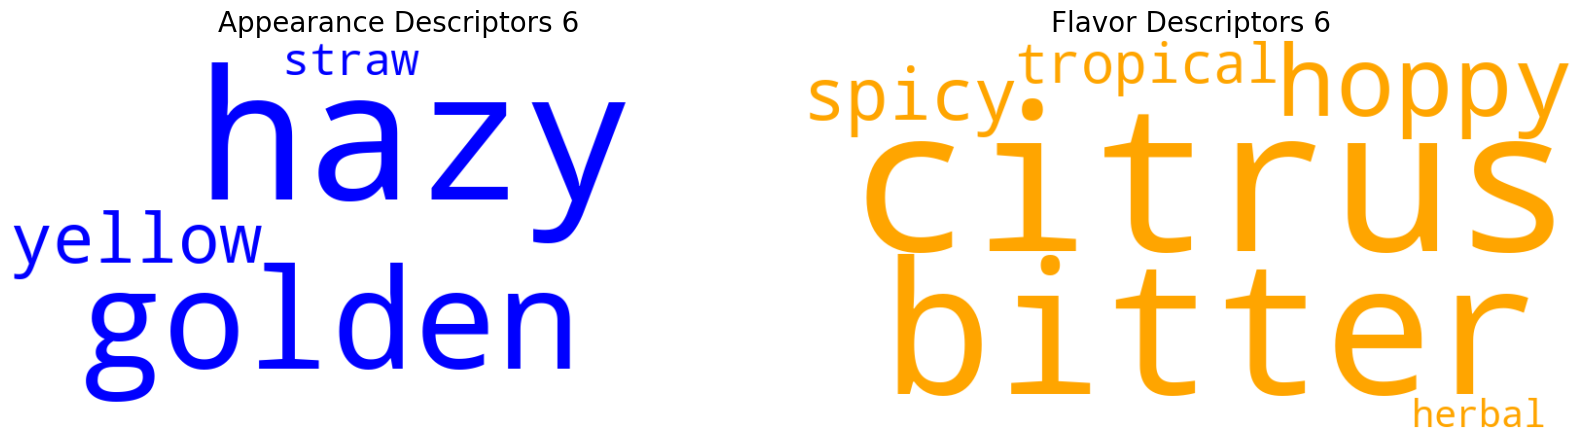

Cluster 7


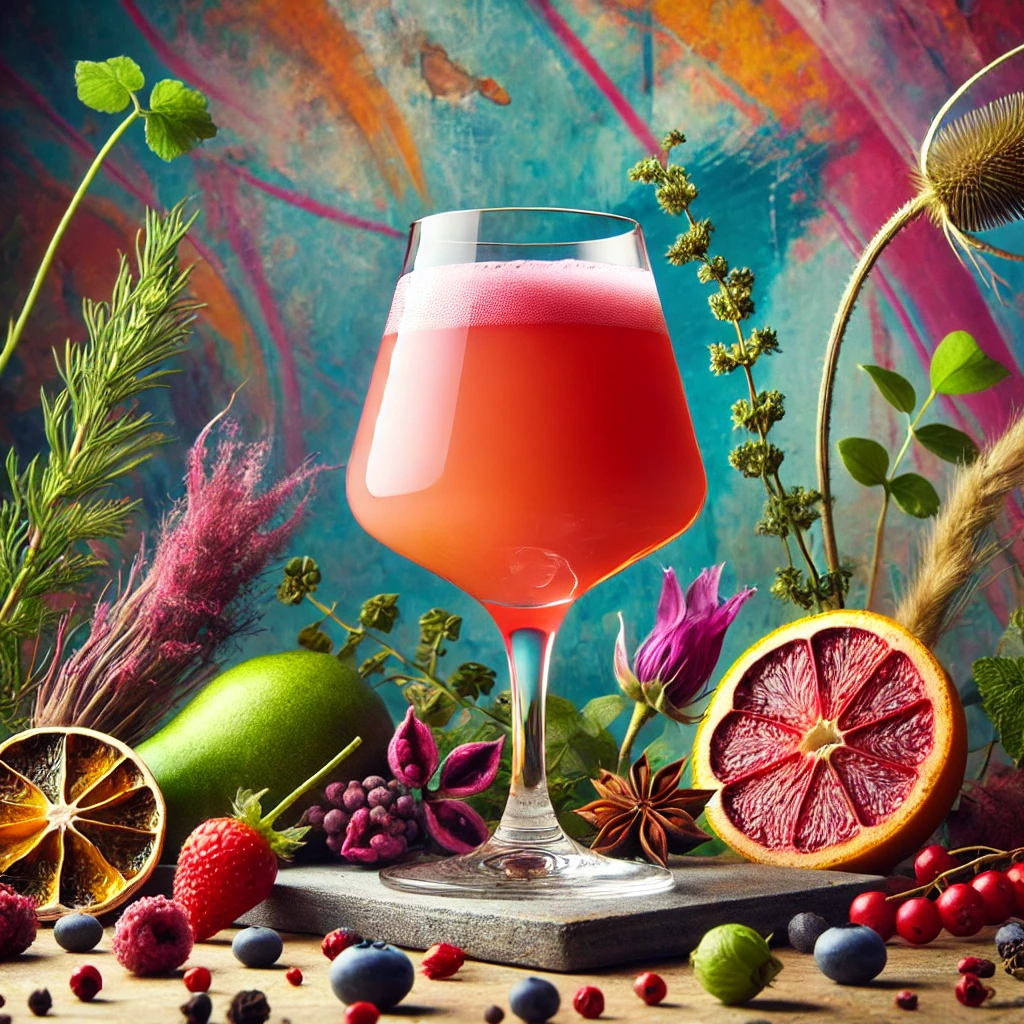

Total number of selected IPA reviews: 70430
Total number of selected Non-IPA reviews: 70430


100%|██████████| 70430/70430 [01:00<00:00, 1159.63it/s]


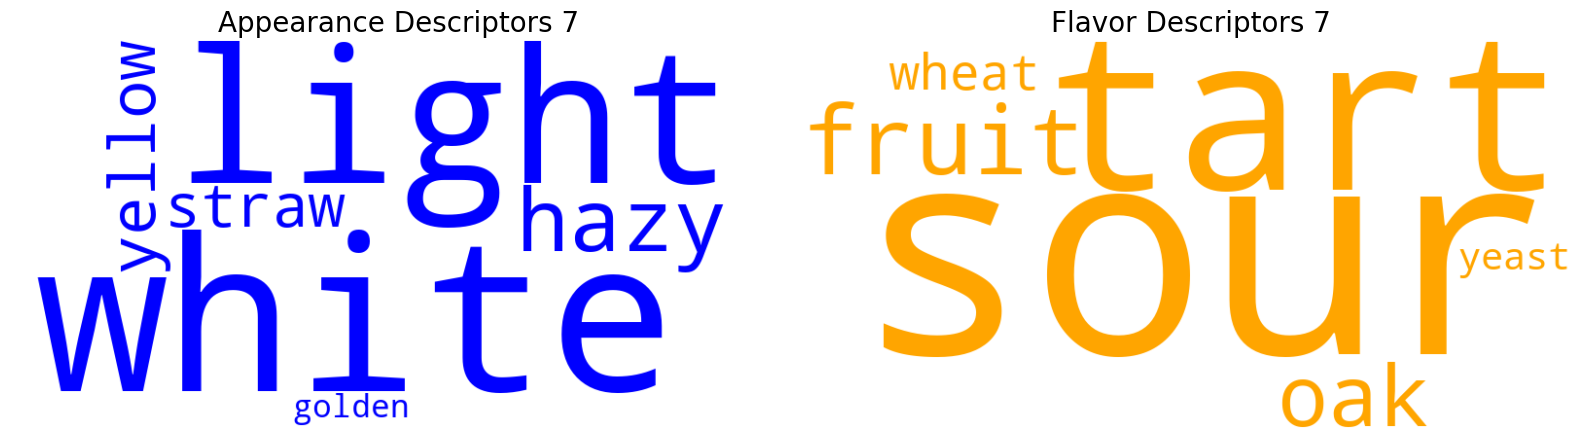

Cluster 8


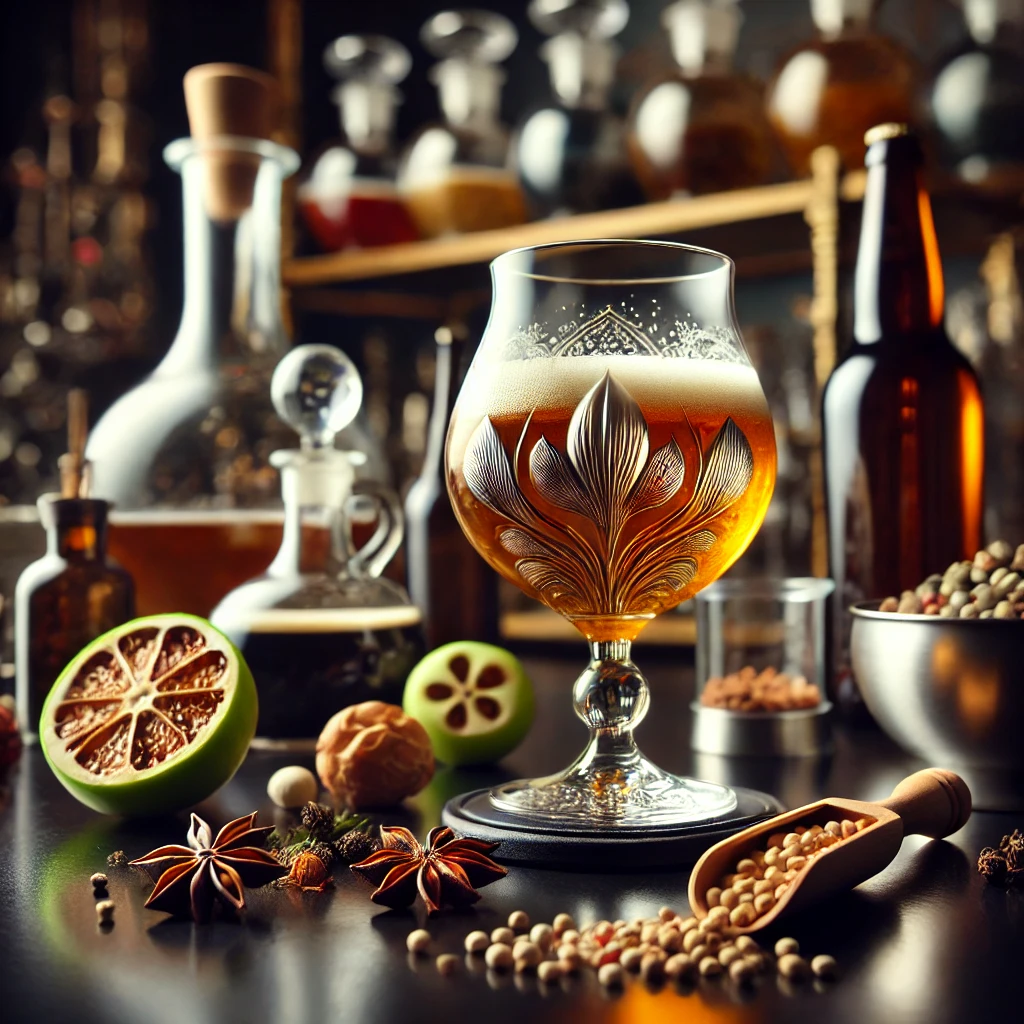

Total number of selected IPA reviews: 15188
Total number of selected Non-IPA reviews: 15188


100%|██████████| 15188/15188 [00:12<00:00, 1181.78it/s]


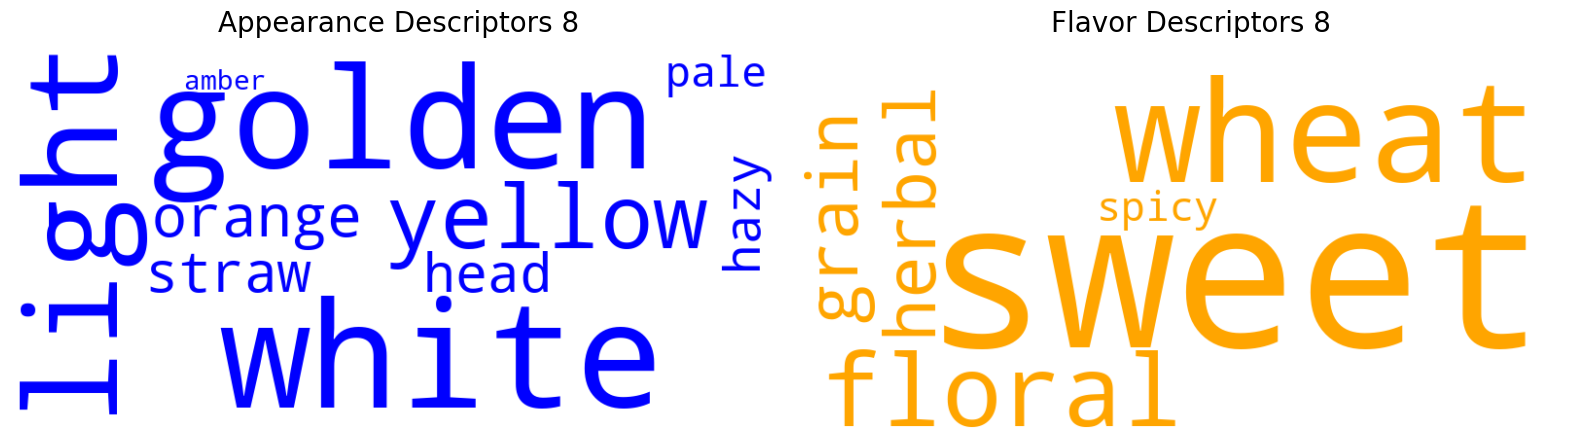

In [32]:
for i in range(0,9):
    print(f"Cluster {i}")
    #Display beer images: 
    display(Image(filename=image_path + all_files[i]))

    #Create "camembert" with top beers
    create_sunburst(i, assigned_cluster, f'Cluster {i}', 'darkred')
    cluster_number = i
    cluster_reviews_df = ba_reviews_df[ba_reviews_df['beer_id'].isin(assigned_cluster[assigned_cluster['cluster'] == cluster_number]['beer_id'])].copy()
    cluster_reviews_df.reset_index(drop=True, inplace=True)
    other_reviews_df = ba_reviews_df[~ba_reviews_df['beer_id'].isin(assigned_cluster[assigned_cluster['cluster'] == cluster_number]['beer_id'])].copy()
    other_reviews_df.reset_index(drop=True, inplace=True)

    #Filter our subsets and balance
    cluster_reviews_filtered, other_reviews_filtered = filter_beer_reviews(cluster_reviews_df, other_reviews_df)
    #print(cluster_reviews_filtered.head(1), other_reviews_filtered.head(1))
    #Tokenize
    cluster_reviews_filtered, other_reviews_filtered = tokenize(cluster_reviews_filtered, other_reviews_filtered)
    #Extract top words
    cluster_top_words, other_top_words = extract_top_words(cluster_reviews_filtered, other_reviews_filtered)

    #Check what appearance terms our cluster correspond to
    appearance_comparison_df = compute_criterium(cluster_top_words, other_top_words, appearance_descriptors)

    ##Check what taste terms our cluster correspond to
    flavor_comparison_df = compute_criterium(cluster_top_words, other_top_words, flavor_descriptors)

    top_appearance = appearance_comparison_df[appearance_comparison_df['Difference'] > 0]
    top_flavor = flavor_comparison_df[flavor_comparison_df['Difference'] > 0]

    print_cloud(top_appearance, top_flavor, i)
    

Interesting! Now we are interested in particular in cluster 2. This cluster correspond to the IPA cluster! Let's prove it by analysing the main flavors associated with IPA beers and with cluster 2 are similar.

Cluster Flavors

Total number of selected IPA reviews: 100000
Total number of selected Non-IPA reviews: 100000


100%|██████████| 100000/100000 [01:39<00:00, 1002.13it/s]
C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_21780\2042218060.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


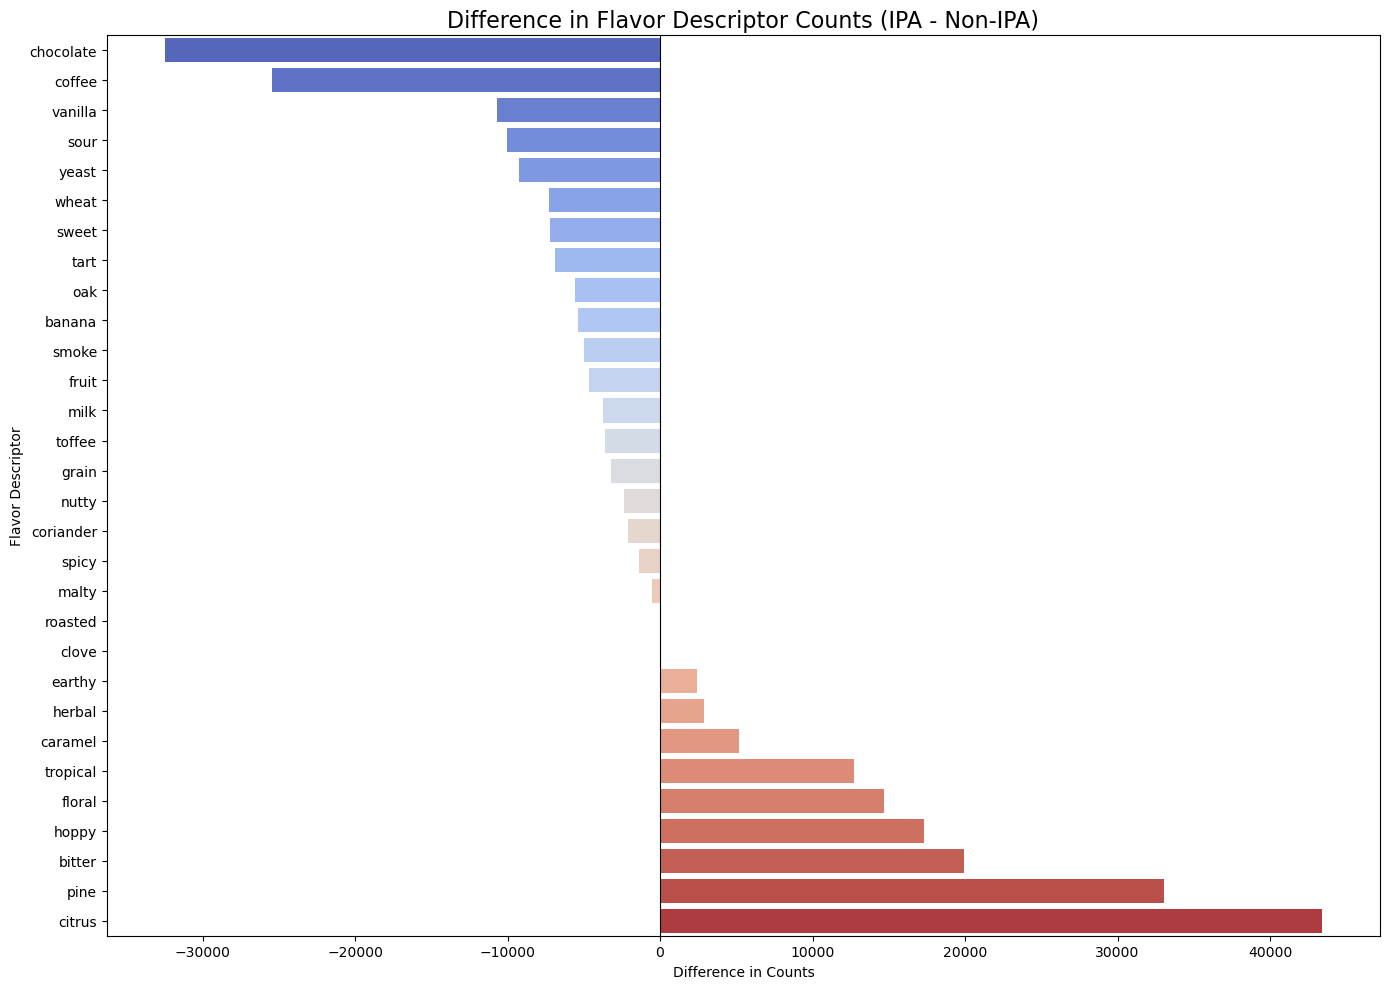

In [ ]:
cluster_number = 2
cluster_reviews_df = ba_reviews_df[ba_reviews_df['beer_id'].isin(assigned_cluster[assigned_cluster['cluster'] == cluster_number]['beer_id'])].copy()
cluster_reviews_df.reset_index(drop=True, inplace=True)
other_reviews_df = ba_reviews_df[~ba_reviews_df['beer_id'].isin(assigned_cluster[assigned_cluster['cluster'] == cluster_number]['beer_id'])].copy()
other_reviews_df.reset_index(drop=True, inplace=True)
#Filter our subsets and balance
cluster_reviews_filtered, other_reviews_filtered = filter_beer_reviews(cluster_reviews_df, other_reviews_df)
#print(cluster_reviews_filtered.head(1), other_reviews_filtered.head(1))
#Tokenize
cluster_reviews_filtered, other_reviews_filtered = tokenize(cluster_reviews_filtered, other_reviews_filtered)
#Extract top words
cluster_top_words, other_top_words = extract_top_words(cluster_reviews_filtered, other_reviews_filtered)
#Check what appearance terms our cluster correspond to
appearance_comparison_df = compute_criterium(cluster_top_words, other_top_words, appearance_descriptors)
##Check what taste terms our cluster correspond to
flavor_comparison_df = compute_criterium(cluster_top_words, other_top_words, flavor_descriptors)

# Sort by absolute difference
sorted_flavors = flavor_comparison_df.sort_values('Difference', ascending=True)

# Plot difference bar chart
plt.figure(figsize=(14, 10))
sns.barplot(
    data=sorted_flavors,
    x='Difference',
    y='Appear',
    palette='coolwarm',
    orient='h'
)
plt.title('Difference in Flavor Descriptor Counts (IPA - Non-IPA)', size=16)
plt.xlabel('Difference in Counts')
plt.ylabel('Flavor Descriptor')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


IPA cluster

In [33]:
macro_group = [
    'American IPA', 'English India Pale Ale (IPA)', 'Belgian IPA', 'American Double / Imperial IPA'
]

Total number of selected IPA reviews: 100000
Total number of selected Non-IPA reviews: 100000


100%|██████████| 100000/100000 [01:26<00:00, 1152.03it/s]
C:\Users\Qrnqult\AppData\Local\Temp\ipykernel_21780\2288198654.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


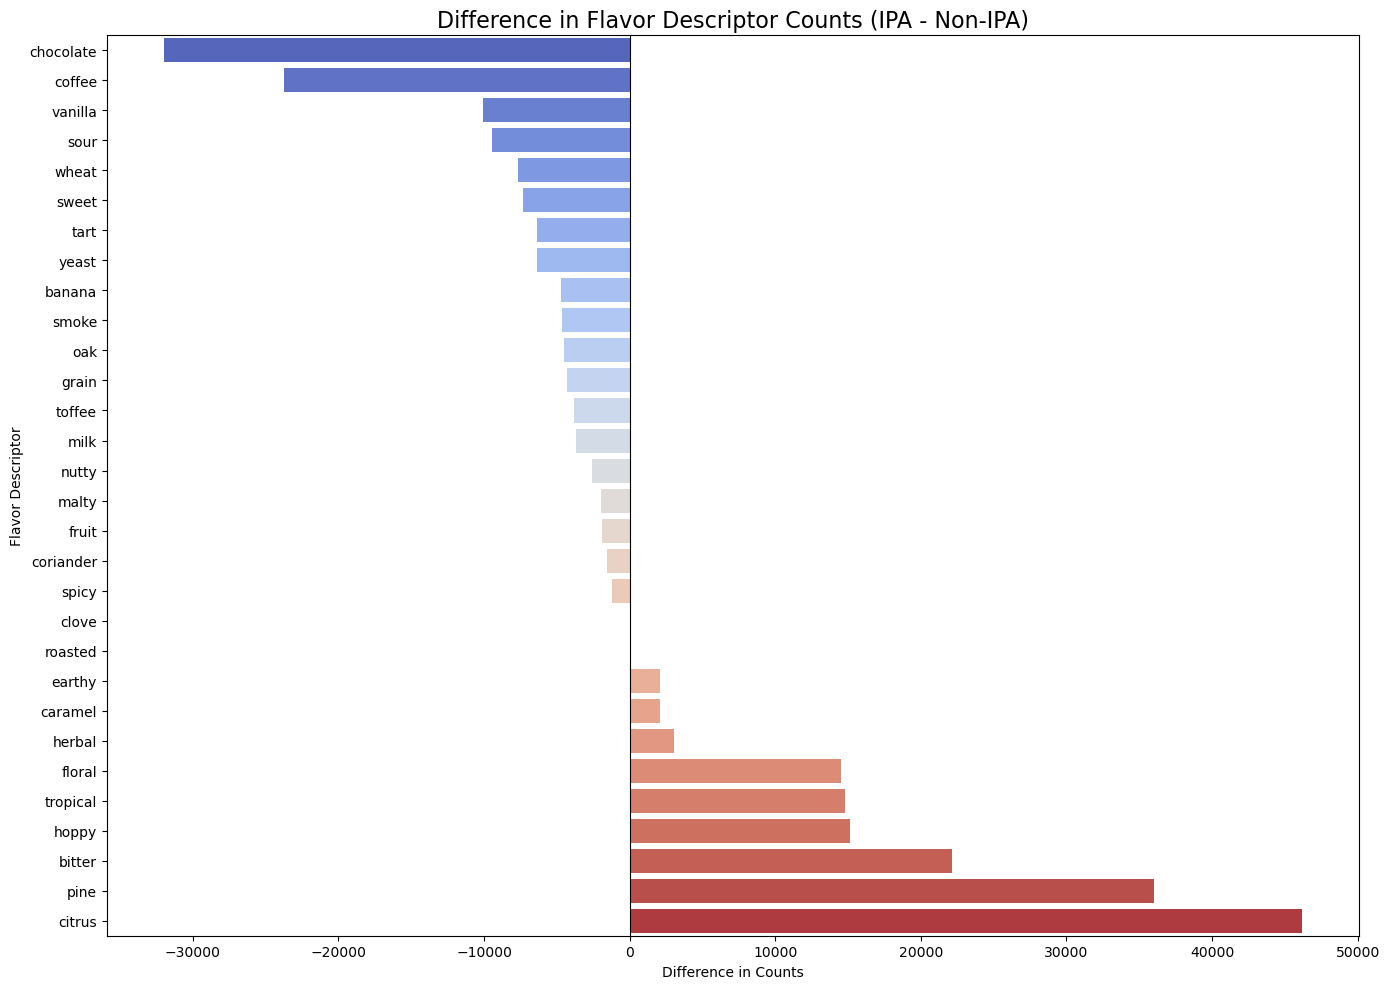

In [ ]:
cluster_reviews_df = ba_reviews_df[ba_reviews_df['style'].isin(macro_group)].copy()
cluster_reviews_df.reset_index(drop=True, inplace=True)
other_reviews_df = ba_reviews_df[~ba_reviews_df['style'].isin(macro_group)].copy()
other_reviews_df.reset_index(drop=True, inplace=True)
#Filter our subsets and balance
cluster_reviews_filtered, other_reviews_filtered = filter_beer_reviews(cluster_reviews_df, other_reviews_df)
#print(cluster_reviews_filtered.head(1), other_reviews_filtered.head(1))
#Tokenize
cluster_reviews_filtered, other_reviews_filtered = tokenize(cluster_reviews_filtered, other_reviews_filtered)
#Extract top words
cluster_top_words, other_top_words = extract_top_words(cluster_reviews_filtered, other_reviews_filtered)
#Check what appearance terms our cluster correspond to
appearance_comparison_df = compute_criterium(cluster_top_words, other_top_words, appearance_descriptors)
##Check what taste terms our cluster correspond to
flavor_comparison_df = compute_criterium(cluster_top_words, other_top_words, flavor_descriptors)

# Sort by absolute difference
sorted_flavors = flavor_comparison_df.sort_values('Difference', ascending=True)

# Plot difference bar chart
plt.figure(figsize=(14, 10))
sns.barplot(
    data=sorted_flavors,
    x='Difference',
    y='Appear',
    palette='coolwarm',
    orient='h'
)
plt.title('Difference in Flavor Descriptor Counts (IPA - Non-IPA)', size=16)
plt.xlabel('Difference in Counts')
plt.ylabel('Flavor Descriptor')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


This shows that there is no big difference between IPA and the cluster 2 in terms of flavors. We'll then use cluster 2 as a proxy of the IPA style for the rest of the analysis!

Let's check now the ditribution of the quantity of ABV contained in the beers. This would help us to find the normal quantity of alcool a brewery has to consider while brewing a new beer depending of the cluster.

In [99]:
cluster_mapping = {
    0: 'Light and Refreshing Lagers',
    1: 'Dark and Strong Ales',
    2: 'Hop-Forward IPAs',
    3: 'Rich and Roasty Stouts',
    4: 'Belgian and Wheat Styles',
    5: 'Malty and Balanced Ales',
    6: 'Citrusy and Balanced IPAs',
    7: 'Sour and Experimental Beers',
    8: 'Specialty and Niche Styles'
}

In [100]:
def show_distribution(cluster_name, name, title, xlabel):
    # Set the style for seaborn
    sns.set(style="whitegrid")

    # Define a color palette with distinct colors for 9 clusters
    palette = sns.color_palette("tab10", n_colors=9)

    # Create the plot
    plt.figure(figsize=(12, 6))

    legend_labels = []

    for i in range(9):  # Loop through clusters 0 to 8
        # Filter data for the current cluster
        cluster = cluster_name[cluster_name['cluster'] == i]
        
        # Plot ABV distributions with unique colors
        sns.kdeplot(
            cluster[name],
            fill=False,
            label=f'Cluster {i}',
            color=palette[i]  # Assign a unique color
        )

        legend_labels.append(cluster_mapping[i]) 


    # Add titles and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')

    plt.legend(labels=legend_labels)

    # Display the plot
    plt.show()

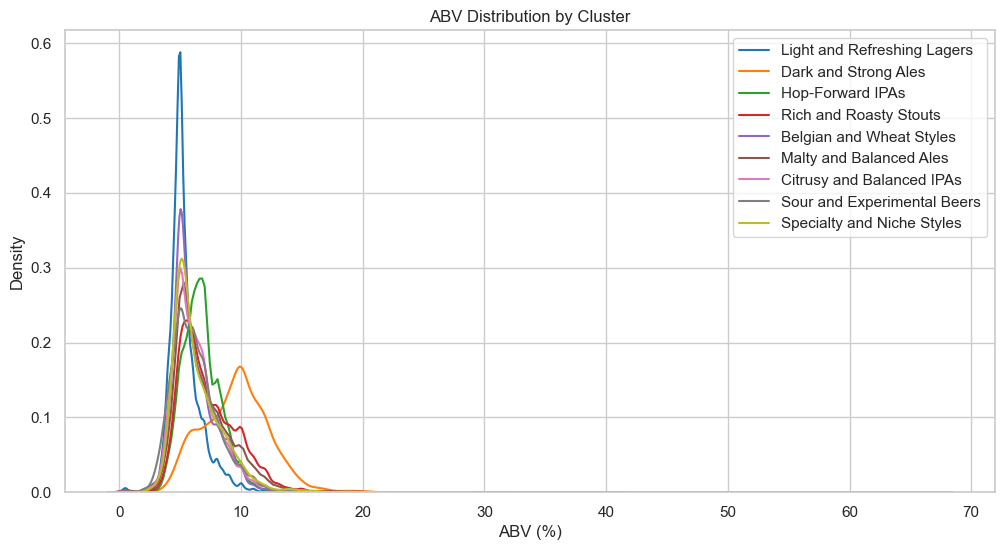

In [102]:
show_distribution(assigned_cluster, 'abv', 'ABV Distribution by Cluster', 'ABV (%)')

We see a net difference between "Dark and Strong Ales" and "Light and Refreshing Lagers" in terms of % of alcool. It would'nt make any sense to brew a Lager containing 10% ABV. Is it even possible?

In [115]:
def clean_location(location):
    #The goal of this method is to change the name of some countries
    #to be able to use them on the shapefile
    if isinstance(location, str):  # Check if location is a string
        country = location.split(',')[0].strip()
        # Replace "United States" with "United States of America"
        if country == "United States":
            return "United States of America"
        if country == "England":
            return "United Kingdom"
        return country
    return None

# Apply the cleanup function
ba_users_df['cleaned_location'] = ba_users_df['location'].apply(clean_location)

users_df_selected = ba_users_df[['user_id', 'cleaned_location']]
ratings_df_selected = ba_ratings_df[['user_id', 'beer_id', 'brewery_id', 'style', 'abv', 'appearance', 'aroma', 'palate', 'rating', 'taste', 'date']]

# Merging on 'user_id'
#Contains the ratings and the location of the users
merged_df = pd.merge(users_df_selected, ratings_df_selected, on='user_id', how='right')

def filter_location(min_ratings, final_merged_df):
    location_ratings = final_merged_df.groupby('cleaned_location').count()

    # Filter locations with more than 1000 ratings
    locations_over_min = location_ratings[location_ratings['rating'] > min_ratings].index

    # Filter the original DataFrame to include only these locations
    return final_merged_df[final_merged_df['cleaned_location'].isin(locations_over_min)]

#merged_df = filter_location(1000, merged_df)
assigned_cluster_ratings = pd.merge(result_df[['beer_id', 'cluster']], merged_df, on='beer_id', how='right')
assigned_cluster_ratings = assigned_cluster_ratings[assigned_cluster_ratings['cluster'].between(0, 8)]
assigned_cluster_ratings['datetime'] = pd.to_datetime(assigned_cluster_ratings['date'], unit='s')
# Extract the year from the datetime
assigned_cluster_ratings['year'] = assigned_cluster_ratings['datetime'].dt.year
assigned_cluster_ratings['month'] = assigned_cluster_ratings['datetime'].dt.month
assigned_cluster_ratings = assigned_cluster_ratings[assigned_cluster_ratings['year'].between(2007, 2017)]

In [61]:
def show_evolution(cluster, name):
    pivot_df = cluster.pivot(index=name, columns='cluster', values='rating').fillna(0)
    pivot_df_normalized = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

    # Plotting the stacked bar chart with normalized data (percentage)
    ax = pivot_df_normalized.plot(kind='bar', stacked=True, figsize=(14, 7))

    # Update the legend with cluster names instead of cluster numbers
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [cluster_mapping[int(float(label))] for label in labels]  # Convert labels to integers first
    ax.legend(handles, new_labels, title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adding labels and title
    plt.title(f'Stacked Bar Chart of Ratings by Cluster and {name} (Clusters 0-8) - Percentage')
    plt.xlabel('name')
    plt.ylabel('Percentage of Total Rating')
    plt.xticks(rotation=90)
    plt.tight_layout()  # Adjust layout for better fit

    # Show the plot
    plt.show()

Here we check which beer clusters are more seasonal. This would help us to advice breweries when to stock and produce with beer during the years. For example the demand of "rich and roasty beers" drops a lot during the summer: a brewery should'nt produce too many beers for this season. At the contrary, during the summer, the demand for IPA's augments: the stocks should be available to satisfy the demand!

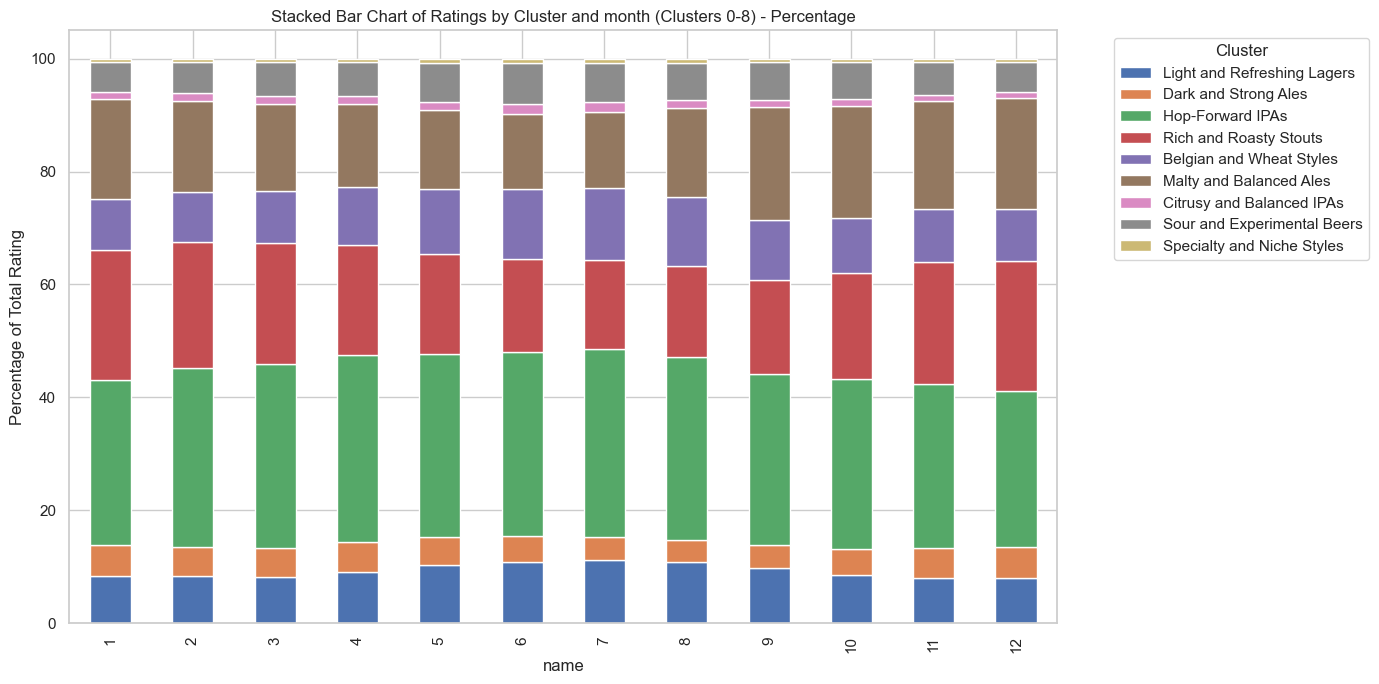

In [116]:
month_cluster = assigned_cluster_ratings.groupby(['month', 'cluster']).count().reset_index()
month_cluster = month_cluster[['month', 'cluster', 'rating']]
show_evolution(month_cluster, "month")

We inverstigate here what's the size of the breweries for each style of beers. What should be expected on the market in terms of brewery sizes? For example, if we want to do some counsulting for a really small brewery, brewing only a few 2-3 beers, we would probably recommand them to brew lager, as lagers are brewed by smaller breweries. Brewing "Dark and Strong Ales" might be difficult because it's more likely to be brewed by well known breweries and brands. 

Brewery size distribution based on the beers assigned in each cluster

In [111]:
beers_clusters = pd.merge(result_df[['beer_id', 'cluster']], ba_beers_df, on='beer_id', how='right')
ba_breweries_numbers = ba_breweries_df[['id', 'nbr_beers']]
breweries_cluster = pd.merge(beers_clusters, ba_breweries_numbers, left_on='brewery_id', right_on='id', how='left')

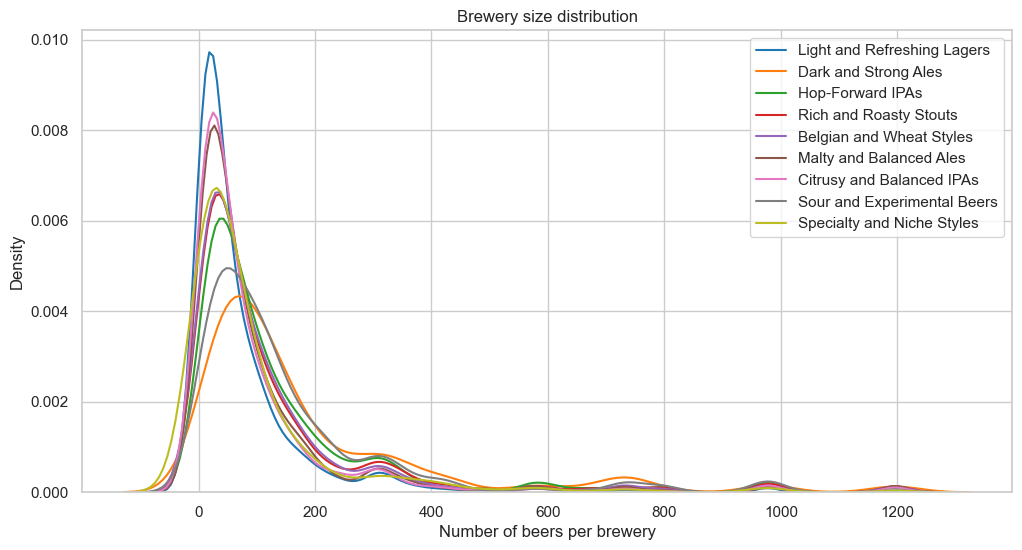

In [ ]:
show_distribution(breweries_cluster, 'nbr_beers', 'Brewery size distribution', 'Number of beers per brewery')

Brewery size distribution based on the ratings given on each cluster

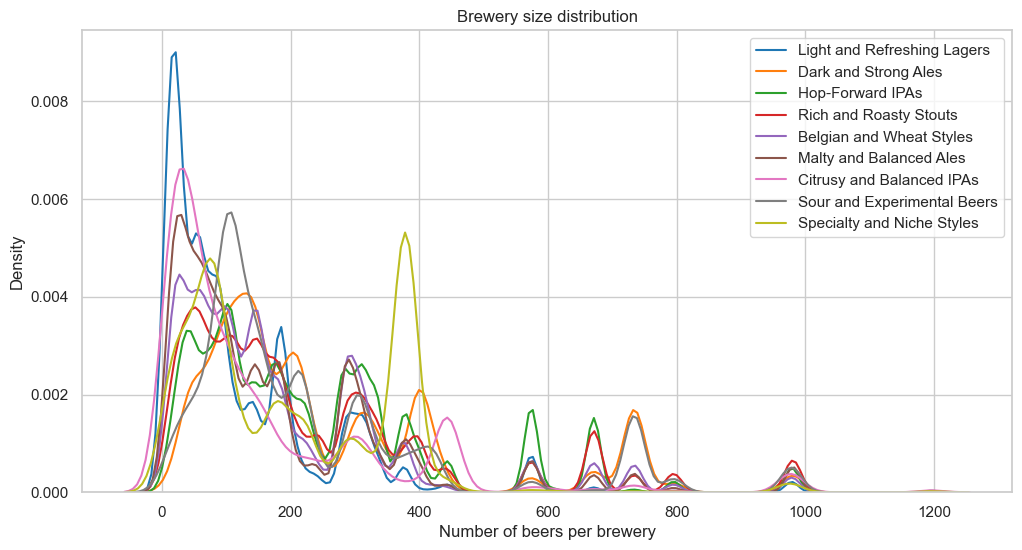

In [117]:
breweries_cluster_ratings = pd.merge(assigned_cluster_ratings, ba_breweries_numbers, left_on='brewery_id', right_on='id', how='left')
show_distribution(breweries_cluster_ratings, 'nbr_beers', 'Brewery size distribution', 'Number of beers per brewery')

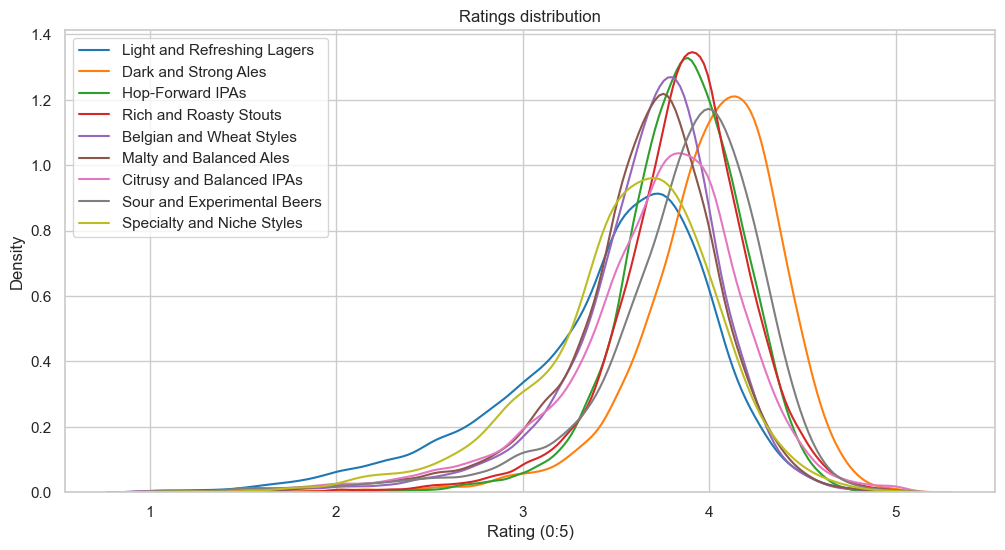

In [ ]:
show_distribution(assigned_cluster_ratings, 'rating', 'Ratings distribution', 'Rating (0:5)')